In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import zipfile
from IPython.display import clear_output
import glob
import pandas as pd
import os

In [3]:
from numpy import nan
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv(os.path.join('training_data.csv'))

# Now drop the columns
columns_to_drop = [
    "Patient ID", "Recording locations", "Murmur locations", "Most audible location",
    "Systolic murmur timing", "Systolic murmur shape", "Systolic murmur grading",
    "Systolic murmur pitch", "Systolic murmur quality", "Diastolic murmur timing",
    "Diastolic murmur shape", "Diastolic murmur grading", "Diastolic murmur pitch",
    "Diastolic murmur quality", "Campaign", "Additional ID", "Recording locations:",
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

scaler = MinMaxScaler()
columns_to_normalize = ['Weight', 'Height']
data_to_normalize = df[columns_to_normalize]
normalized_data = scaler.fit_transform(data_to_normalize)
df_normalized = pd.DataFrame(normalized_data, columns=columns_to_normalize)
df[columns_to_normalize] = df_normalized


df['Pregnancy status'] = df['Pregnancy status'].apply(lambda x: 1 if x else 0)
sex2int = {'Male': 0, 'Female': 1}
df['Sex'] = df['Sex'].apply(lambda x: sex2int[x] if x in sex2int else -1)
df = df[df['Sex'] != -1]

age2int = {'Neonate': 0, 'Infant': 1, 'Child': 2, 'Adolescent': 3}
df['Age'] = df['Age'].apply(lambda x: age2int[x] if x in age2int else -1)
df = df[df['Age'] != -1]

df = df[df['Murmur'] != 'Unknown']
df['Murmur'] = df['Murmur'].apply(lambda x: 0 if x == 'Absent' else (1 if x == 'Present' else 2))

outcome2int = {'Normal': 0, 'Abnormal': 1}
df['Outcome'] = df['Outcome'].apply(lambda x: outcome2int[x] if x in outcome2int else -1)
df = df[df['Outcome'] != -1]

df = df.select_dtypes(include=[np.number])
df.dropna(inplace=True)


print(df.head())
print("Number of data sample rows:", df.shape[0])

   Age  Sex    Height    Weight  Pregnancy status  Murmur  Outcome
0    2    1  0.434483  0.125346                 0       0        1
1    2    1  0.468966  0.099539                 0       1        1
3    2    0  0.434483  0.125346                 0       1        1
4    2    0  0.358621  0.082028                 0       1        1
6    2    1  0.393103  0.107834                 0       0        1
Number of data sample rows: 759


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


noise_scale = 0.01

numerical_cols = ['Weight', 'Height']
for col in numerical_cols:
    df[col] += np.random.normal(loc=0.0, scale=noise_scale, size=df[col].shape)

# Apply SMOTE for data aug
smote = SMOTE()
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_sm, y_sm = smote.fit_resample(X, y)
df_sm = pd.DataFrame(X_sm, columns=X.columns)
df_sm['Outcome'] = y_sm


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sm.drop('Outcome', axis=1))
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
y_encoded = to_categorical(df_sm['Outcome'])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.1, random_state=42)

# augmented data
print(df_sm.head())
print("Number of data sample rows after SMOTE:", df_sm.shape[0])
print("Example input\n", df_sm.drop('Outcome', axis=1).loc[0])

   Age  Sex    Height    Weight  Pregnancy status  Murmur  Outcome
0    2    1  0.446520  0.118830                 0       0        1
1    2    1  0.457870  0.120511                 0       1        1
2    2    0  0.423518  0.131510                 0       1        1
3    2    0  0.356813  0.071461                 0       1        1
4    2    1  0.396024  0.102232                 0       0        1
Number of data sample rows after SMOTE: 768
Example input
 Age                 2.00000
Sex                 1.00000
Height              0.44652
Weight              0.11883
Pregnancy status    0.00000
Murmur              0.00000
Name: 0, dtype: float64


In [7]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Dropout(0.10),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100


/Users/cogniveon/src/HeartMurmurClassification/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5140 - loss: 0.6888 - val_accuracy: 0.6403 - val_loss: 0.6672
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.6529 - loss: 0.6446 - val_accuracy: 0.6547 - val_loss: 0.6523
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.6820 - loss: 0.5970 - val_accuracy: 0.6835 - val_loss: 0.6649
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.6451 - loss: 0.6134 - val_accuracy: 0.6547 - val_loss: 0.6601
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6527 - loss: 0.6077 - val_accuracy: 0.6475 - val_loss: 0.6574
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6605 - loss: 0.6117 - val_accuracy: 0.6187 - val_loss: 0.6709
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.6460 - loss: 0.6094 - val_accuracy: 0.6259 - val_loss: 0.6673
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.6691 - loss: 0.6166 - val_accuracy: 0.6331 - v

In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6268 - loss: 0.7269 
Test Accuracy: 63.64%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,320 (270.79 KB)

 Trainable params: 23,106 (90.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,214 (180.53 KB)

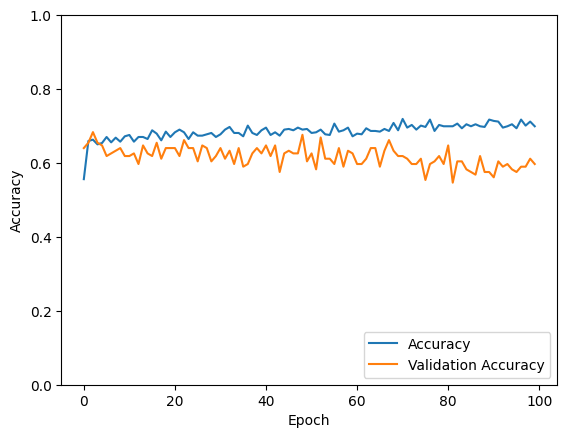

In [9]:
model.summary()

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [10]:
model.save('patient_outcome_classifier.keras')